In [1]:
# import numpy, pandas and matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import minimize
from scipy.optimize import minimize

In [2]:
# Function that converts pLab in sqrt(s)
def computeSqrts(pLab):
    """
        Given the magnitude of the proton beam momentum this function
        computes the respetive sqrt(s).
        The proton beam four momentum is (sqrt(mp**2+pLab**2), 0, 0, pLab)
        The proton four momentum is (mp,0,0,0) because it is at rest
        Then s = (p_gamma + mp)^2 - p_gamma^2
    """
    mp = 0.938
    # mass of the proton is 0.938 GeV
    return np.sqrt((mp+np.sqrt(mp*mp+pLab*pLab))**2-pLab*pLab)

In [3]:
# First we process the raw data into a new file format that can be read easily by pandas
f = open("SigmaProtonProton_raw.txt", "r")
new_f = open("SigmaProtonProton_new_raw.txt", "w")
string = f.readline()
while string != '':
    line_list = string.split()
    ref_list = line_list[9:]
    line_list = line_list[:9]
    new_line = '\t'.join(line_list)
    ref_string = " ".join(ref_list)
    new_f.write(new_line+'\t' + ref_string + '\n')
    string = f.readline()
f.close()
new_f.close()

In [4]:
def loadSigmaProtonProtonData(file_name, pLab_Min, pLab_Max, output_file_name):
    """
        Loads the PDG data contained in the file file_name.
        Then it selects only the experimental points with
        pLab_MIN < pLab < pLab_MAX.
        Then creates an output file with the following columns
        ["W(GeV)", "WErrorp", "WErrorm", "sigma(nb)", "Errorp", "Errorm"]
        The Errorp and Errorm will be equal and are given by
        sqrt(stat_error**2 + syst_error**2). The stat_error and syst_error values
        are assumed to be the average of the corresponding plus and minus errors.
    """
    # Load raw data
    exp_data_raw = pd.read_csv(file_name, sep = '\t')
    condition = (exp_data_raw["PLAB(GEV/C)"] > pLab_Min) & (exp_data_raw["PLAB(GEV/C)"] < pLab_Max)
    # Read pLab values as well their minimum and maximum values
    pLab_vals = np.array(exp_data_raw[condition]["PLAB(GEV/C)"])
    pLab_min_vals = np.array(exp_data_raw[condition]["PLAB_MIN"])
    pLab_max_vals = np.array(exp_data_raw[condition]["PLAB_MAX"])
    # Convert the pLab values into sqrt(s) values
    sqrtS_vals = computeSqrts(pLab_vals)
    sqrtS_min_vals = computeSqrts(pLab_min_vals)
    sqrtS_max_vals = computeSqrts(pLab_max_vals)
    sqrtS_err_plus = sqrtS_max_vals - sqrtS_vals
    sqrtS_err_minus = sqrtS_vals - sqrtS_min_vals
    # Read cross-section values
    sigma_vals = np.array(exp_data_raw[condition]["SIG(MB)"])
    # Compute the statistical error as the average of STA_ERR+ and STA_ERR-
    stat_error_plus = np.array(exp_data_raw[condition]["STA_ERR+"])
    stat_error_minus = np.array(exp_data_raw[condition]["STA_ERR-"])
    stat_error = 0.5 * (stat_error_plus + stat_error_minus)
    # Compute the systematic error as the average of STA_ERR+ and STA_ERR-
    syst_error_plus = sigma_vals * np.array(exp_data_raw[condition]["SY_ER+(PCT)"]) / 100.0
    syst_error_minus = sigma_vals * np.array(exp_data_raw[condition]["SY_ER-(PCT)"]) / 100.0
    syst_error = 0.5 * (syst_error_plus + syst_error_minus)
    # Compute the total error as sqrt(stat_error**2 + syst_error**2)
    error_vals = np.sqrt(stat_error**2 + syst_error**2)
    # Create new data frame with columns ["sqrtS", "sqrtSErrorPlus", "sqrtSErrorMinus", "sigma", "Errorp", "Errorm"]
    exp_data = pd.DataFrame({"W(GeV)":sqrtS_vals, "WErrorp":sqrtS_err_plus, "WErrorm":sqrtS_err_minus,
                        "sigma(mb)":sigma_vals, "Errorp":error_vals, "Errorm": error_vals})
    exp_data.to_csv(output_file_name, sep ='\t', index = False)

In [5]:
# Create a dataset with sqrt(s) < 386 GeV
loadSigmaProtonProtonData("SigmaProtonProton_new_raw.txt", 10, 10**7, "SigmaProtonProton_data_W_lt_386.txt")
# Create a dataset with 10 < sqrt(s) < 386 GeV
loadSigmaProtonProtonData("SigmaProtonProton_new_raw.txt", 52.3585, 10**7, "SigmaProtonProton_data_10_lt_W_lt_386.txt")
# Create a dataset with sqrt(s) < 10 TeV (to include LHC data)
loadSigmaProtonProtonData("SigmaProtonProton_new_raw.txt", 10, 5*10**7, "SigmaProtonProton_data_W_lt_10000.txt")
# Create a dataset with 10 GeV < sqrt(s) < 10 TeV (to include LHC data)
loadSigmaProtonProtonData("SigmaProtonProton_new_raw.txt", 52.3585, 5*10**7, "SigmaProtonProton_data_10_lt_W_lt_10000.txt")
# Create a dataset with sqrt(s) <= 14 TeV (to include LHC data)
loadSigmaProtonProtonData("SigmaProtonProton_new_raw.txt", 4, 10**10, "SigmaProtonProton_data.txt")

In [6]:
def plotExpData(data_file):
    """
        Plots the experimental data contained in the file data_file.
    """
    # Read the file
    exp_data = pd.read_csv(data_file, sep ='\t')
    sqrtS_vals = np.array(exp_data["W(GeV)"])
    sigma_vals = np.array(exp_data["sigma(mb)"])
    error_vals = 0.5*(np.array(exp_data["Errorp"])+np.array(exp_data["Errorm"]))
    plt.errorbar(sqrtS_vals, sigma_vals, error_vals, fmt='o', markersize=0.5)
    plt.xlabel(r'$\sqrt{s}$')
    plt.xlim(1,10**6)
    plt.ylabel(r'$\sigma(mb)$')
    plt.xscale("log")

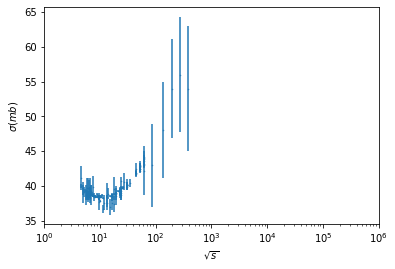

In [7]:
plotExpData("SigmaProtonProton_data_W_lt_386.txt")

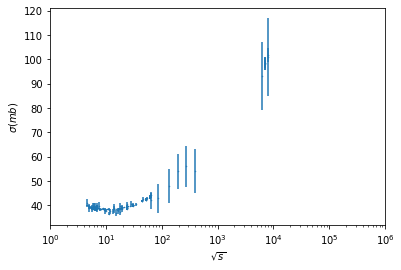

In [8]:
plotExpData("SigmaProtonProton_data_W_lt_10000.txt")

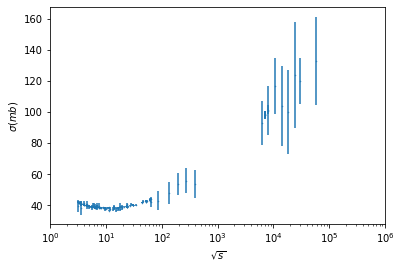

In [9]:
plotExpData("SigmaProtonProton_data.txt")

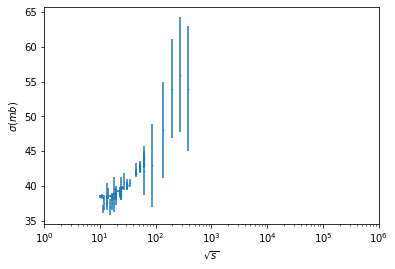

In [10]:
plotExpData("SigmaProtonProton_data_10_lt_W_lt_386.txt")

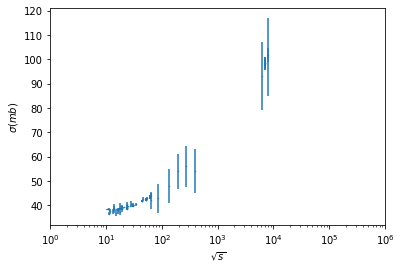

In [11]:
plotExpData("SigmaProtonProton_data_10_lt_W_lt_10000.txt")

In [12]:
def sigmaPredUnvec(s,a,b,c,d):
    j1 = 1.17144
    j2 = 1.08301
    j3 = 0.974516
    j4 = 0.912894
    return a*s**(j1-1) + b*s**(j2-1) + c*s**(j3-1) + d*s**(j4-1)

sigmaPred = np.vectorize(sigmaPredUnvec)

def chi2(x, data):
    a = x[0]
    b = x[1]
    c = x[2]
    d = x[3]
    W = np.array(data["W(GeV)"])
    Wplus = W + np.array(data["WErrorp"])
    Wminus = W - np.array(data["WErrorm"])
    sigma_pred = sigmaPred(W*W, a, b, c, d)
    sigma_pred_plus = sigmaPred(Wplus*Wplus, a, b, c, d)
    sigma_pred_minus = sigmaPred(Wminus*Wminus, a, b, c, d)
    delta_sigma_pred = np.maximum(np.absolute(sigma_pred_plus - sigma_pred), np.absolute(sigma_pred - sigma_pred_minus))
    sigma_err = 0.5*(np.array(data["Errorp"])+np.array(data["Errorm"]))
    sigma_exp = np.array(data["sigma(mb)"])
    delta_sigma = np.sqrt(sigma_err*sigma_err + delta_sigma_pred * delta_sigma_pred)
    chi2 = np.sum(((sigma_pred - sigma_exp)/delta_sigma)**2)
    return chi2


In [13]:
# Let's find the best fit for 10 < W < 10000 GeV
x0 = [0, 0, 0, 0]
exp_data = pd.read_csv("SigmaProtonProton_data_10_lt_W_lt_10000.txt", sep ='\t')
best_fit_x = minimize(chi2, x0, args = exp_data, method = "Nelder-Mead").x
chi2_ndof = chi2(best_fit_x, exp_data) / (len(exp_data) - 4)
print(best_fit_x)
print(chi2_ndof)

[ 2.71941449  7.49611288 10.34822974 17.48558196]
1.3609566656200323


In [14]:
# convert c++ result because here we fitted sigma in units of mb while in the c++ code we fitted to GeV^-2 units
GEV_MINUS_2_pars = np.array([7.19131,17.0716,35.6313,36.8793])
mb_pars = GEV_MINUS_2_pars * 3.894 / 10
chi2_ndof = chi2(mb_pars, exp_data) / (len(exp_data) - 4)
print(mb_pars)
print(chi2_ndof)

[ 2.80029611  6.64768104 13.87482822 14.36079942]
1.3978651078026811


In [17]:
# Let's find the best fit for 10 < W < 386 GeV
x0 = [0, 0, 0, 0]
exp_data = pd.read_csv("SigmaProtonProton_data_10_lt_W_lt_386.txt", sep ='\t')
best_fit_x = minimize(chi2, x0, args = exp_data, method = "Nelder-Mead").x
chi2_ndof = chi2(best_fit_x, exp_data) / (len(exp_data) - 4)
print(best_fit_x)
print(chi2_ndof)
# Convert to the expectec c++ result
print(best_fit_x * 10 / 3.894)

[ 3.74732787  5.11653781  8.42998462 21.95400952]
1.2296825014138928
[ 9.62333813 13.1395424  21.64865079 56.37906912]
